
# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #transforms.Resize((14, 14)),
                                       transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-3.0, 3.0)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #transforms.Resize((14, 14)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 170498071/170498071 [00:02<00:00, 62153837.99it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# The model
Let's start with the model we first saw

In [5]:
import torch.nn.functional as F
dropout_value = 0.05
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.convblock1 = nn.Sequential(nn.Conv2d(in_channels=3,  out_channels=6,
                                                  kernel_size=(3, 3), padding=1, bias=False),
                                                  nn.ReLU(),nn.LayerNorm([6,32,32]),nn.Dropout(dropout_value))
        self.convblock2 = nn.Sequential(nn.Conv2d(in_channels=6, out_channels=6,
                                                  kernel_size=(3, 3), padding=1, bias=False),
                                                  nn.ReLU(),nn.LayerNorm([6,32,32]),nn.Dropout(dropout_value))
        self.convblock3 = nn.Sequential(nn.Conv2d(in_channels=6, out_channels=6, kernel_size=(1, 1), padding=1, bias=False))
        self.pool1 = nn.MaxPool2d(2, 2)

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(nn.Conv2d(in_channels=6, out_channels=8,
                                                  kernel_size=(3, 3), padding=1, bias=False),
                                                  nn.ReLU(),nn.LayerNorm([8,17,17]),nn.Dropout(dropout_value))
        self.convblock5 = nn.Sequential(nn.Conv2d(in_channels=8, out_channels=8,
                                                  kernel_size=(3, 3), padding=1, bias=False),
                                                  nn.ReLU(),nn.LayerNorm([8,17,17]),nn.Dropout(dropout_value))
        self.convblock6 = nn.Sequential(nn.Conv2d(in_channels=8, out_channels=8,
                                                  kernel_size=(3, 3), padding=1, bias=False),
                                                  nn.ReLU(),nn.LayerNorm([8,17,17]),nn.Dropout(dropout_value))
        self.convblock7 = nn.Sequential(nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(1, 1), padding=1, bias=False))
        self.pool2 = nn.MaxPool2d(2, 2)

        # CONVOLUTION BLOCK 3
        self.convblock8 = nn.Sequential(nn.Conv2d(in_channels=8, out_channels=12,
                                                  kernel_size=(3, 3), padding=1, bias=False),
                                        nn.ReLU(),nn.LayerNorm([12,9,9]),nn.Dropout(dropout_value))
        self.convblock9 = nn.Sequential(nn.Conv2d(in_channels=12, out_channels=12,
                                                  kernel_size=(3, 3), padding=1, bias=False),
                                        nn.ReLU(),nn.LayerNorm([12,9,9]),nn.Dropout(dropout_value))
        self.convblock10 = nn.Sequential(nn.Conv2d(in_channels=12, out_channels=12,
                                                   kernel_size=(3, 3), padding=1, bias=False),
                                         nn.ReLU(),nn.LayerNorm([12,9,9]),nn.Dropout(dropout_value))
        self.gap = nn.Sequential(nn.AvgPool2d(kernel_size=9))
        self.convblock11 = nn.Sequential(nn.Conv2d(in_channels=12, out_channels=10, kernel_size=(1, 1), padding=0, bias=False))

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.pool2(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)
        x = self.gap(x)
        x = self.convblock11(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [6]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 32, 32]             162
              ReLU-2            [-1, 6, 32, 32]               0
         LayerNorm-3            [-1, 6, 32, 32]          12,288
           Dropout-4            [-1, 6, 32, 32]               0
            Conv2d-5            [-1, 6, 32, 32]             324
              ReLU-6            [-1, 6, 32, 32]               0
         LayerNorm-7            [-1, 6, 32, 32]          12,288
           Dropout-8            [-1, 6, 32, 32]               0
            Conv2d-9            [-1, 6, 34, 34]              36
        MaxPool2d-10            [-1, 6, 17, 17]               0
           Conv2d-11            [-1, 8, 17, 17]             432
             ReLU-12            [-1, 8, 17, 17]               0
        LayerNorm-13            [-1, 8, 17, 17]           4,624
          Dropout-14            [-

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [7]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

This time let's add a scheduler for out LR.

In [8]:
model =  Net().to(device)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=1.8267991542816162 Batch_id=390 Accuracy=25.90: 100%|██████████| 391/391 [00:45<00:00,  8.60it/s]



Test set: Average loss: 1.7378, Accuracy: 3586/10000 (35.86%)

EPOCH: 1


Loss=1.8021959066390991 Batch_id=390 Accuracy=35.54: 100%|██████████| 391/391 [00:48<00:00,  8.05it/s]



Test set: Average loss: 1.6005, Accuracy: 4013/10000 (40.13%)

EPOCH: 2


Loss=1.7524993419647217 Batch_id=390 Accuracy=40.98: 100%|██████████| 391/391 [00:46<00:00,  8.38it/s]



Test set: Average loss: 1.4833, Accuracy: 4434/10000 (44.34%)

EPOCH: 3


Loss=1.4617644548416138 Batch_id=390 Accuracy=44.69: 100%|██████████| 391/391 [00:48<00:00,  8.06it/s]



Test set: Average loss: 1.4360, Accuracy: 4657/10000 (46.57%)

EPOCH: 4


Loss=1.4859131574630737 Batch_id=390 Accuracy=47.61: 100%|██████████| 391/391 [00:47<00:00,  8.15it/s]



Test set: Average loss: 1.4109, Accuracy: 4702/10000 (47.02%)

EPOCH: 5


Loss=1.3137387037277222 Batch_id=390 Accuracy=49.57: 100%|██████████| 391/391 [00:48<00:00,  8.05it/s]



Test set: Average loss: 1.3048, Accuracy: 5200/10000 (52.00%)

EPOCH: 6


Loss=1.3765650987625122 Batch_id=390 Accuracy=51.14: 100%|██████████| 391/391 [00:48<00:00,  8.01it/s]



Test set: Average loss: 1.2891, Accuracy: 5302/10000 (53.02%)

EPOCH: 7


Loss=1.246372938156128 Batch_id=390 Accuracy=52.94: 100%|██████████| 391/391 [00:48<00:00,  8.07it/s]



Test set: Average loss: 1.2379, Accuracy: 5484/10000 (54.84%)

EPOCH: 8


Loss=1.2481071949005127 Batch_id=390 Accuracy=54.21: 100%|██████████| 391/391 [00:49<00:00,  7.84it/s]



Test set: Average loss: 1.1810, Accuracy: 5701/10000 (57.01%)

EPOCH: 9


Loss=1.2943326234817505 Batch_id=390 Accuracy=55.27: 100%|██████████| 391/391 [00:47<00:00,  8.32it/s]



Test set: Average loss: 1.1965, Accuracy: 5632/10000 (56.32%)

EPOCH: 10


Loss=1.3389612436294556 Batch_id=390 Accuracy=56.31: 100%|██████████| 391/391 [00:50<00:00,  7.74it/s]



Test set: Average loss: 1.1751, Accuracy: 5655/10000 (56.55%)

EPOCH: 11


Loss=1.0973740816116333 Batch_id=390 Accuracy=57.15: 100%|██████████| 391/391 [00:47<00:00,  8.30it/s]



Test set: Average loss: 1.1484, Accuracy: 5878/10000 (58.78%)

EPOCH: 12


Loss=1.268694281578064 Batch_id=390 Accuracy=58.00: 100%|██████████| 391/391 [00:50<00:00,  7.78it/s]



Test set: Average loss: 1.1092, Accuracy: 5973/10000 (59.73%)

EPOCH: 13


Loss=0.9980872869491577 Batch_id=390 Accuracy=58.67: 100%|██████████| 391/391 [00:47<00:00,  8.18it/s]



Test set: Average loss: 1.1158, Accuracy: 5939/10000 (59.39%)

EPOCH: 14


Loss=1.1301058530807495 Batch_id=390 Accuracy=59.22: 100%|██████████| 391/391 [00:50<00:00,  7.68it/s]



Test set: Average loss: 1.0735, Accuracy: 6184/10000 (61.84%)

EPOCH: 15


Loss=1.0822380781173706 Batch_id=390 Accuracy=60.04: 100%|██████████| 391/391 [00:48<00:00,  8.08it/s]



Test set: Average loss: 1.0583, Accuracy: 6175/10000 (61.75%)

EPOCH: 16


Loss=1.1470718383789062 Batch_id=390 Accuracy=60.49: 100%|██████████| 391/391 [00:50<00:00,  7.78it/s]



Test set: Average loss: 1.0540, Accuracy: 6253/10000 (62.53%)

EPOCH: 17


Loss=1.0904262065887451 Batch_id=390 Accuracy=60.64: 100%|██████████| 391/391 [00:48<00:00,  8.00it/s]



Test set: Average loss: 1.0591, Accuracy: 6266/10000 (62.66%)

EPOCH: 18


Loss=1.109447956085205 Batch_id=390 Accuracy=61.08: 100%|██████████| 391/391 [00:51<00:00,  7.64it/s]



Test set: Average loss: 1.0412, Accuracy: 6234/10000 (62.34%)

EPOCH: 19


Loss=1.1547600030899048 Batch_id=390 Accuracy=61.69: 100%|██████████| 391/391 [00:51<00:00,  7.64it/s]



Test set: Average loss: 1.0347, Accuracy: 6328/10000 (63.28%)



# Plot Train and Test loss and Accuracy

Text(0.5, 1.0, 'Test Accuracy')

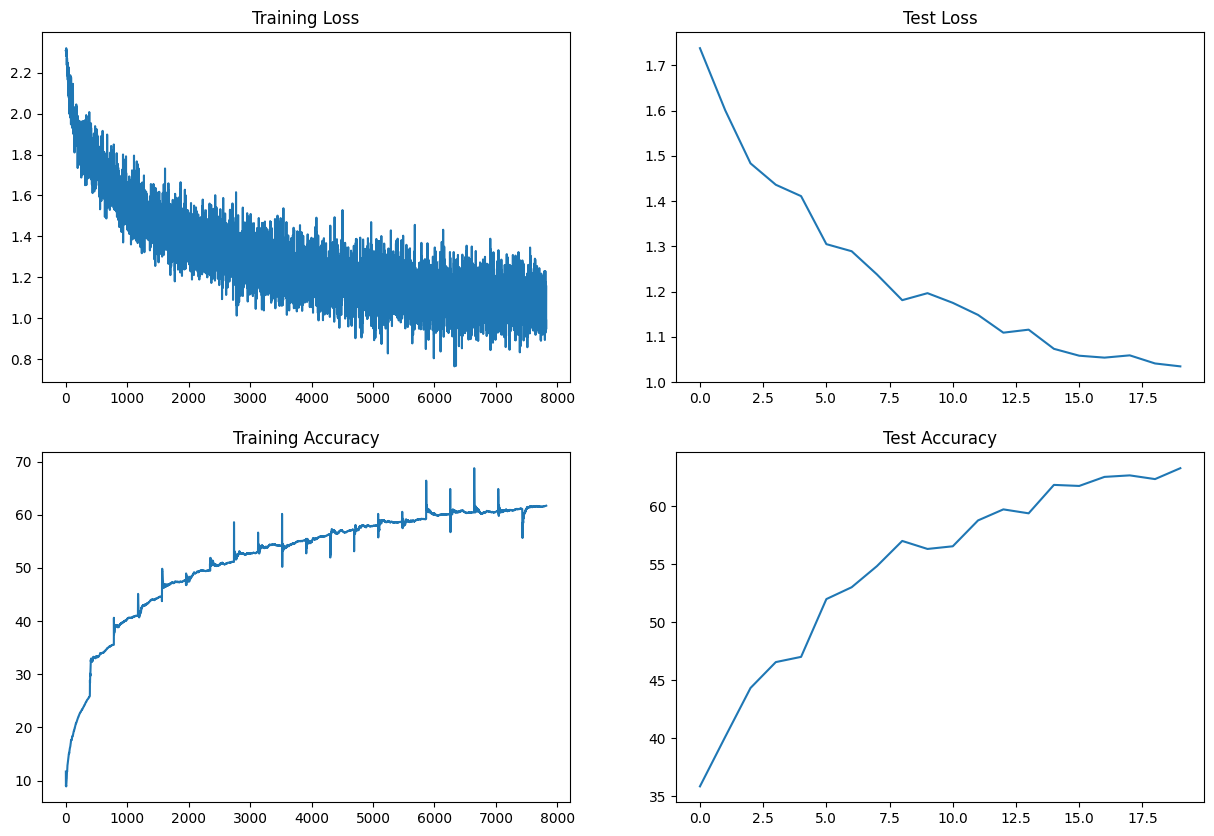

In [9]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

# Visualization of 10 mis-classified images

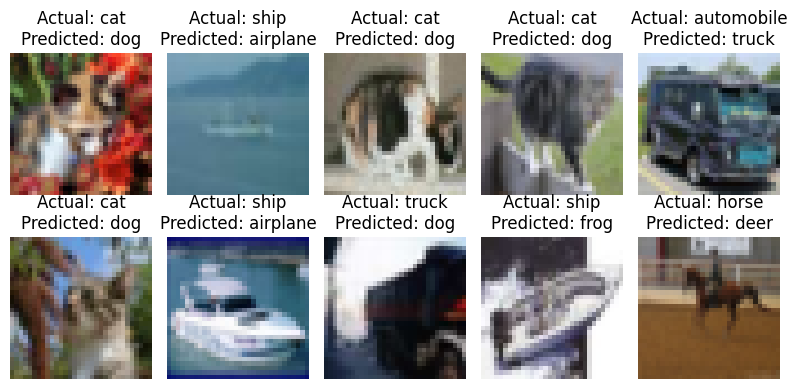

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Define the list of actual labels
y_test = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def show_misclassified_images(net, dataloader, device):
    net.eval()
    with torch.no_grad():
        misclassified_count = 0
        fig, axs = plt.subplots(2, 5, figsize=(8, 4))
        for batch in dataloader:
            inputs, labels = batch
            inputs = inputs.to(device, non_blocking=True)
            outputs = net(inputs)
            predictions = torch.argmax(outputs, dim=1)

            for sample_no in range(batch[0].shape[0]):
                if labels[sample_no] != predictions[sample_no]:
                    actual_label = y_test[labels[sample_no]]  # Get the actual label
                    predicted_label = y_test[predictions[sample_no]]  # Get the predicted label
                    image = inputs[sample_no].cpu().numpy().transpose(1, 2, 0)  # Convert to (H, W, C)
                    image = (image * 0.5) + 0.5  # Normalize pixel values

                    row_idx = misclassified_count // 5
                    col_idx = misclassified_count % 5
                    #axs[row_idx, col_idx].imshow(image.squeeze())
                    axs[row_idx % 2, col_idx].imshow(image.squeeze())
                    axs[row_idx % 2, col_idx].set_title(f"Actual: {actual_label}\nPredicted: {predicted_label}")
                    axs[row_idx % 2, col_idx].axis('off')
                    misclassified_count += 1
                    if misclassified_count >= 10:  # Display only 10 misclassified images
                        break

        plt.tight_layout()
        plt.show()

# Call the function with appropriate arguments (model, test_loader, device)
show_misclassified_images(model, test_loader, device)